# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Văn Lê Bá Thành
- MSSV: 22127390
- Lớp: 22CLC08

## Import các thư viện liên quan

In [374]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

## Helper functions

In [375]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    # YOUR CODE HERE
    raw_image = Image.open(img_path).convert("RGB")
    return raw_image

def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    # YOUR CODE HERE
    plt.imshow(img_2d)

def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    img_path = img_path + "_" + "compressed.png" 
    img_2d.save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    # YOUR CODE HERE
    height, width = img_2d.size
    return np.reshape(img_2d, (width * height, 3)).astype(int)


def kmeans(img_1d, k_clusters, max_iter, init_centroids):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    # YOUR CODE HERE
    centroids = init_centroids_value(img_1d, k_clusters, init_centroids)
    height = img_1d.shape
    labels = np.zeros((height), dtype= 'int8')

    count = 0

    for _ in range(max_iter):
        centroids_old = np.copy(centroids)
        count += 1

        # distance between each pixel and centroids
        distance = np.linalg.norm(img_1d - centroids[: , np.newaxis] , axis = 2)
        # Find the label of each pixel
        labels = np.argmin(distance, axis = 0)

        

        for i in range(k_clusters):
            centroids[i] = np.mean(img_1d[labels == i], axis=0)

        if (np.array_equal(centroids, centroids_old) == True):
            print(count)
            print("break")
            break

    return centroids, labels

    
def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    # YOUR CODE HERE
    height, width = img_2d_shape[0], img_2d_shape[1]
    result = centroids[labels].reshape(height, width, 3)
    result = Image.fromarray(np.uint8(result))
    return result


# Your additional functions here
def init_centroids_value(img_1d, k_clusters, init_centroids):

    centroids = np.array([], dtype=np.float64)
    # Create array with unique value
    new = np.copy([list(i) for i in img_1d])
    new = np.unique(new, axis=0)
    
    # Retrieve length (height * width) and dim of new array
    length, dim = new.shape
    if init_centroids == 'random':
        centroids = np.random.choice(256, size = (k_clusters, dim), replace=False)
    elif init_centroids == 'in_pixels':
        centroids = img_1d[np.random.choice(length, size = k_clusters, replace=False)]
    
    return centroids

## Your tests

In [376]:
from time import time
from io import BytesIO

def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

def variance(dataSet):
    return sum(np.linalg.norm(dataSet - np.mean(dataSet, axis = 0), axis = 1)**2)

def test():
# Input của chương trình
    img_link = input("Nhập đường dẫn ảnh muốn nén: ")
    # img_link = "Test4.png"
    img_name = img_link.rfind('.')
    result_path = img_link[0:img_name]
    print(result_path)
    img_name = img_link[0:img_name].split("\\")[-1] 

    print(img_name)
    ori_img = Image.open(img_link).convert("RGB")
    file_type = input("Nhập loại file ảnh muốn lưu (png hoặc pdf):")

    # Convert, reshape ảnh đã đọc
    ori_pixels = np.array(ori_img)
    ori_img_flatten = convert_img_to_1d(ori_img)
    ori_img_shape = ori_pixels.shape
    ori_img_dim = ori_img.size
    ori_img_size = imageByteSize(ori_img)
    ori_img_n_colors = len(set(ori_img.getdata()))
    print(f"Dung lượng ảnh gốc: {ori_img_size} KB")
    print(f"Số lượng màu ảnh gốc: {ori_img_n_colors}")
    plt.show()

    k_cluster = [3, 5, 7, 20]
    for k in k_cluster:
        t0 = time()
        centroids, labels = kmeans(ori_img_flatten, k, 300, 'in_pixels')
        new_img = generate_2d_img(ori_img_shape, centroids, labels)
        print(f"done in {time() - t0:0.3f}s.")
        new_img = Image.fromarray(np.uint8(new_img))
        new_img_size = imageByteSize(new_img)
        print(f"Dung lượng ảnh nén {k} màu: {new_img_size} KB")
        print(f"Giảm {100-new_img_size/ori_img_size*100}% dung lượng")
        show_img(new_img)
        print(result_path)
        # save_img(new_img, result_path)
        new_img.save(f"{img_name}-{k}.{file_type}")


### Scikit-learn

In [377]:
# # YOUR CODE HERE
# from time import time

# import matplotlib.pyplot as plt
# from PIL import Image 
# import numpy as np

# from sklearn.cluster import KMeans
# from sklearn.datasets import load_sample_image
# from sklearn.metrics import pairwise_distances_argmin
# from sklearn.utils import shuffle

# n_colors = 3

# # Load the Summer Palace photo
# china = Image.open("6.png")

# # Convert to floats instead of the default 8 bits integer coding. Dividing by
# # 255 is important so that plt.imshow works well on float data (need to
# # be in the range [0-1])
# china = np.array(china, dtype=np.float64) / 255

# # Load Image and transform to a 2D numpy array.
# w, h, d = original_shape = tuple(china.shape)
# assert d == 3
# image_array = np.reshape(china, (w * h, d))

# print("Fitting model on a small sub-sample of the data")
# t0 = time()
# image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
# kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
# print(f"done in {time() - t0:0.3f}s.")

# # Get labels for all points
# print("Predicting color indices on the full image (k-means)")
# t0 = time()
# labels = kmeans.predict(image_array)
# print(f"done in {time() - t0:0.3f}s.")


# codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
# print("Predicting color indices on the full image (random)")
# t0 = time()
# labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
# print(f"done in {time() - t0:0.3f}s.")


# def recreate_image(codebook, labels, w, h):
#     """Recreate the (compressed) image from the code book & labels"""
#     return codebook[labels].reshape(w, h, -1)


# # Display all results, alongside original image
# plt.figure(1)
# plt.clf()
# plt.axis("off")
# plt.title("Original image (96,615 colors)")
# plt.imshow(china)

# plt.figure(2)
# plt.clf()
# plt.axis("off")
# plt.title(f"Quantized image ({n_colors} colors, K-Means)")
# plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# plt.figure(3)
# plt.clf()
# plt.axis("off")
# plt.title(f"Quantized image ({n_colors} colors, Random)")
# plt.imshow(recreate_image(codebook_random, labels_random, w, h))
# plt.show()


## Main FUNCTION

In [378]:
# YOUR CODE HERE
def main():
    img_path = input('Enter image\'s path: ')
    max_iter = int(input("Enter max iteration: "))
    k_cluster = int(input("Number of k cluster: "))
    centroidsT = int(input("Initial centroid: \n0) random \n1) in_pixels \nYour choice: "))

    # File name add-on
    if centroidsT == 0:
        centroids_type = 'random'
    elif centroidsT == 1:
        centroids_type = 'in_pixels'
    else:
        print('Invalid centroid initialization method')
        return
    
    img_name = img_path.rfind('.')
    result_path = img_path[0:img_name]

    raw_img = read_img(img_path)
    pix = np.array(raw_img)
    raw_img_shape = pix.shape
    flatten = convert_img_to_1d(raw_img)
    centroids, labels = kmeans(flatten, k_cluster, max_iter, centroids_type)
    output = generate_2d_img(raw_img_shape, centroids, labels)
    
    show_img(output)
    save_img(output, result_path)   
    

C:\Users\admin\Documents\GitHub\Applied-Mathematics-2024-HCMUS\Project-lab-01\5
5
Dung lượng ảnh gốc: 1271.748046875 KB
Số lượng màu ảnh gốc: 91257
13
break
done in 7.668s.
Dung lượng ảnh nén 3 màu: 70.521484375 KB
Giảm 94.45475976563999% dung lượng
C:\Users\admin\Documents\GitHub\Applied-Mathematics-2024-HCMUS\Project-lab-01\5
40
break
done in 21.944s.
Dung lượng ảnh nén 5 màu: 106.0439453125 KB
Giảm 91.66156019872992% dung lượng
C:\Users\admin\Documents\GitHub\Applied-Mathematics-2024-HCMUS\Project-lab-01\5
32
break
done in 20.222s.
Dung lượng ảnh nén 7 màu: 138.25 KB
Giảm 89.12913604705629% dung lượng
C:\Users\admin\Documents\GitHub\Applied-Mathematics-2024-HCMUS\Project-lab-01\5


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\admin\AppData\Local\Temp\ipykernel_21176\3973449059.py:112: RuntimeWarning: invalid value encountered in cast
  centroids[i] = np.mean(img_1d[labels == i], axis=0)


61
break
done in 89.719s.
Dung lượng ảnh nén 20 màu: 240.458984375 KB
Giảm 81.0922466155252% dung lượng
C:\Users\admin\Documents\GitHub\Applied-Mathematics-2024-HCMUS\Project-lab-01\5


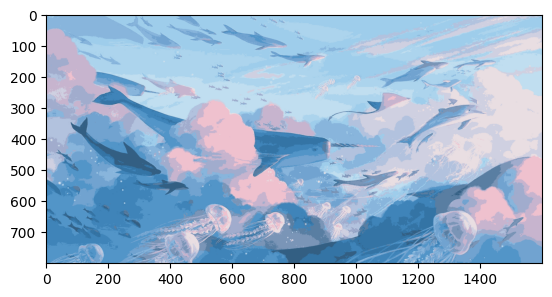

In [379]:
# Call main function
# main()
test()